<a href="https://colab.research.google.com/github/PavanproJack/Fruit-Detection-in-Orchards/blob/master/Yolo_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -r yolov5/requirements.txt 

Cloning into 'yolov5'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 1472 (delta 40), reused 43 (delta 17), pack-reused 1394
Receiving objects: 100% (1472/1472), 5.92 MiB | 13.59 MiB/s, done.
Resolving deltas: 100% (979/979), done.
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-5vjpxa71
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-5vjpxa71
     |████████████████████████████████| 20.4MB 1.3MB/s 
     |████████████████████████████████| 276kB 54.8MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=a5d795c9575fd9194bb7d24b2f6ea453b922d3d78c8231b146b163f7d1543566
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266989 

In [2]:
%cd yolov5/

import torch
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.5.1+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [3]:
%cd ../

/content


In [4]:
!curl -L "https://app.roboflow.ai/ds/XsIHtjCgyR?key=hE0r8ieffA" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0    823      0  0:00:01  0:00:01 --:--:--   823
100 12.6M  100 12.6M    0     0  7223k      0  0:00:01  0:00:01 --:--:-- 25.2M
Archive:  roboflow.zip
 extracting: test/images/mango_img_1253_png.rf.53cdf8786fac77a9aac7f0f951e91a5a.jpg  
 extracting: test/images/mango_img_1340_png.rf.4d0fc05910d2e402c65b6d6a2a52af0d.jpg  
 extracting: test/images/mango_img_1245_png.rf.465764274770f0784b8ce5bdbb38d848.jpg  
 extracting: test/images/mango_img_1317_png.rf.3b408022d4f1cce3c27be3255584d502.jpg  
 extracting: test/images/mango_img_1283_png.rf.242da4bc18bd5c6979c3c4f5ed3b6302.jpg  
 extracting: test/images/mango_img_1044_png.rf.523d270adb15b4474beab9ee1adc3ef4.jpg  
 extracting: test/images/mango_img_1285_png.rf.79c4256ed3e74a6d4cbe331bb6756a2d.jpg  
 extracting: test/images/mango_img_1101_png.rf.2cec44024f0d

In [5]:
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['0']

In [6]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [7]:
with open('yolov5/models/custom_yolov5s.yaml', 'w') as f:
  # parameters
  f.write('nc: ' + num_classes + '\n')
  #f.write('nc: ' + str(len(class_labels)) + '\n')
  f.write('depth_multiple: 0.33'  + '\n') # model depth multiple
  f.write('width_multiple: 0.50'  + '\n')  # layer channel multiple
  f.write('\n')
  f.write('anchors:' + '\n')
  f.write('  - [10,13, 16,30, 33,23] ' + '\n')
  f.write('  - [30,61, 62,45, 59,119]' + '\n')
  f.write('  - [116,90, 156,198, 373,326] ' + '\n')
  f.write('\n')

  f.write('backbone:' + '\n')
  f.write('  [[-1, 1, Focus, [64, 3]],' + '\n')
  f.write('   [-1, 1, Conv, [128, 3, 2]],' + '\n')
  f.write('   [-1, 3, Bottleneck, [128]],' + '\n')
  f.write('   [-1, 1, Conv, [256, 3, 2]],' + '\n')
  f.write('   [-1, 9, BottleneckCSP, [256]],' + '\n')
  f.write('   [-1, 1, Conv, [512, 3, 2]], ' + '\n')
  f.write('   [-1, 9, BottleneckCSP, [512]],' + '\n')
  f.write('   [-1, 1, Conv, [1024, 3, 2]],' + '\n')
  f.write('   [-1, 1, SPP, [1024, [5, 9, 13]]],' + '\n')
  f.write('   [-1, 6, BottleneckCSP, [1024]],' + '\n')
  f.write('  ]' + '\n')
  f.write('\n')

  f.write('head:'  + '\n')
  f.write('  [[-1, 3, BottleneckCSP, [1024, False]],'  + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  f.write('   [-2, 1, nn.Upsample, [None, 2, "nearest"]],' + '\n')
  
  f.write('   [[-1, 6], 1, Concat, [1]],' + '\n')
  f.write('   [-1, 1, Conv, [512, 1, 1]],' + '\n')
  f.write('   [-1, 3, BottleneckCSP, [512, False]],' + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  
  f.write('   [-2, 1, nn.Upsample, [None, 2, "nearest"]],' + '\n')
  f.write('   [[-1, 4], 1, Concat, [1]],' + '\n')
  f.write('   [-1, 1, Conv, [256, 1, 1]],' + '\n')
  f.write('   [-1, 3, BottleneckCSP, [256, False]],' + '\n')
  f.write('   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],' + '\n')
  f.write('\n' )
  f.write('   [[], 1, Detect, [nc, anchors]],' + '\n')
  f.write('  ]' + '\n')

print('custom model config written!')

custom model config written!


In [8]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data ../data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results --nosave --cache

/content/yolov5
Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
Namespace(batch_size=16, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='../data.yaml', device='', epochs=100, evolve=False, hyp='', img_size=[416], multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=True, notest=False, rect=False, resume=False, single_cls=False, weights='')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

2020-07-13 08:12:09.036344: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/compat/__init__.py", line 47, in tf
    from tensorboard.compat import notf
ImportError: cannot import name 'notf'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "train.py", line 402

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'Colab Notebooks'   Yolov4_attempts   Yolov4_tiny_attempts   Yolov5_attempts


In [ ]:
!ls /mydrive/Yolov5_attempts/

last_yolov5s_results.pt  Yolo_v5_weights.sh


In [ ]:
!cp /content/yolov5/runs/exp3_yolov5s_results/weights/last_yolov5s_results.pt /mydrive/Yolov5_attempts/

In [12]:
!python detect.py --weights /mydrive/Yolov5_attempts/last_yolov5s_results.pt --img 416 --conf 0.4 --source ../test/images


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=416, iou_thres=0.5, output='inference/output', save_txt=False, source='../test/images', update=False, view_img=False, weights=['/mydrive/Yolov5_attempts/last_yolov5s_results.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Fusing layers... Model Summary: 120 layers, 6.85311e+06 parameters, 6.31725e+06 gradients
image 1/42 /content/test/images/mango_img_1002_png.rf.835c9b3c0972f5ac8afae78dbf2a7b27.jpg: 416x416 15 0s, Done. (0.014s)
image 2/42 /content/test/images/mango_img_1006_png.rf.ee2638eaabbfd9a4d06a894bbbdf9c4a.jpg: 416x416 6 0s, Done. (0.009s)
image 3/42 /content/test/images/mango_img_1015_png.rf.b56b571b8a09edfe5114ebf0e09edff9.jpg: 416x416 6 0s, Done. (0.009s)
image 4/42 /content/test/images/mango_img_1019_png.rf.cb3dcffa3b848317c9a8ac81ae1cead3.jpg: 416x416 11 0s, Done. (0.009s)
image 5/42 /content/test/images/mango_img_1027_png.rf.e0

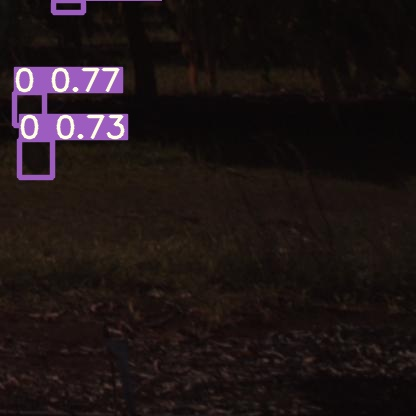

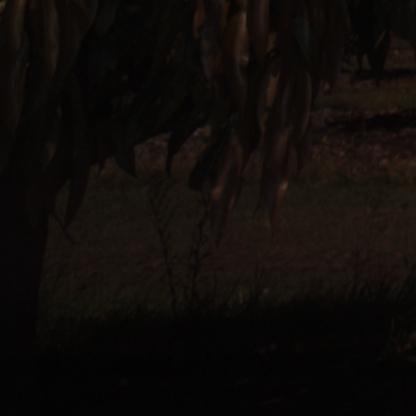

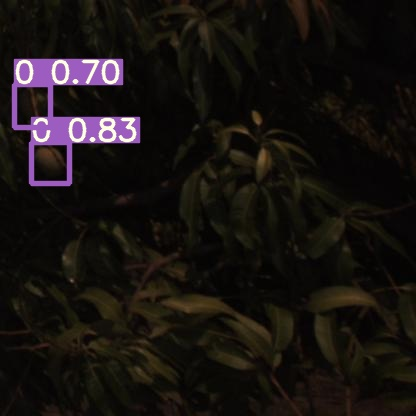

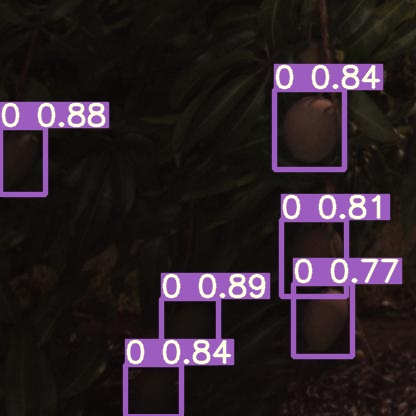

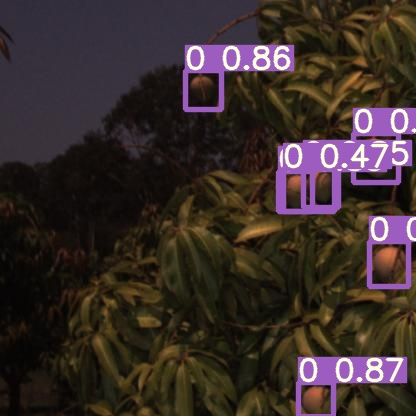

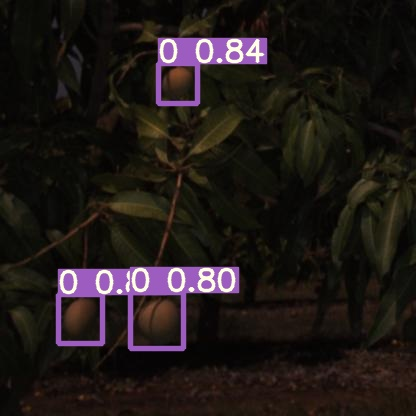

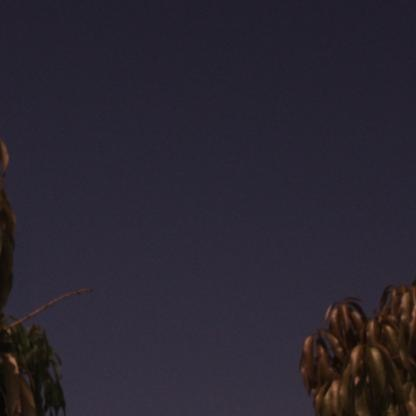

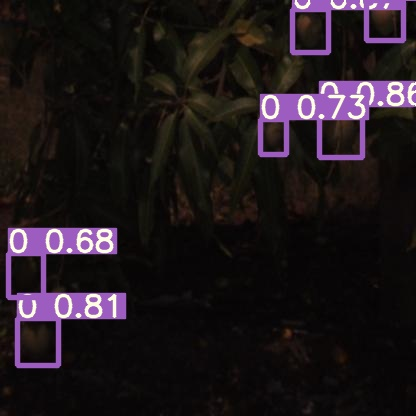

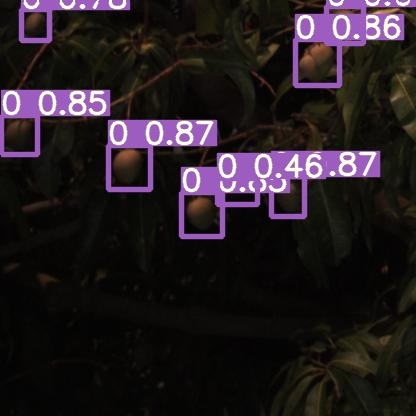

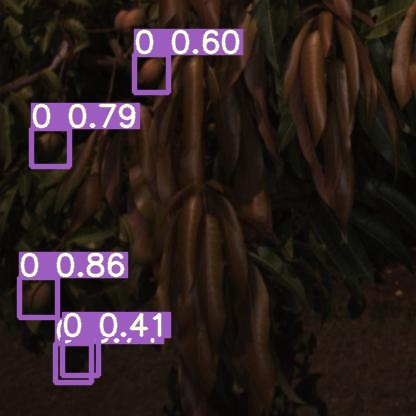

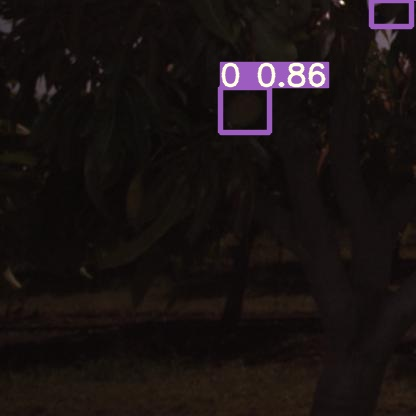

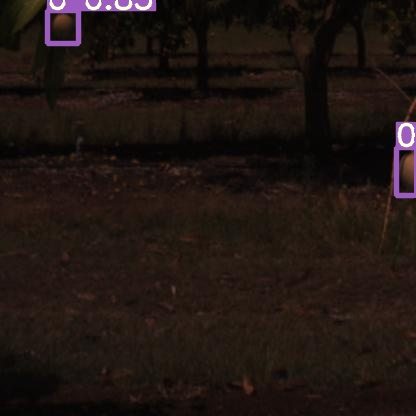

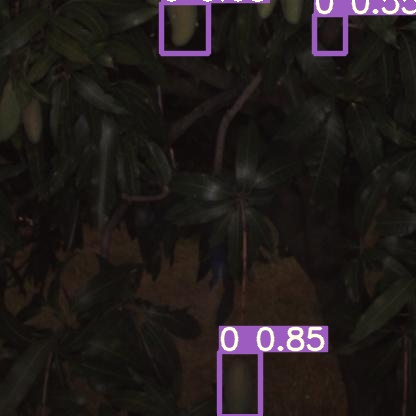

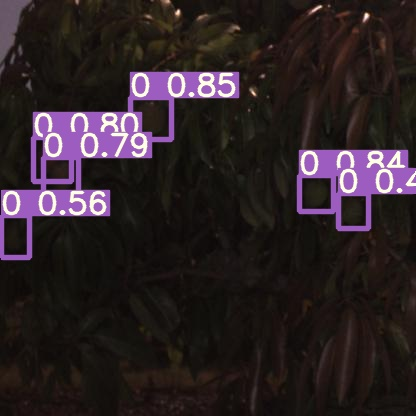

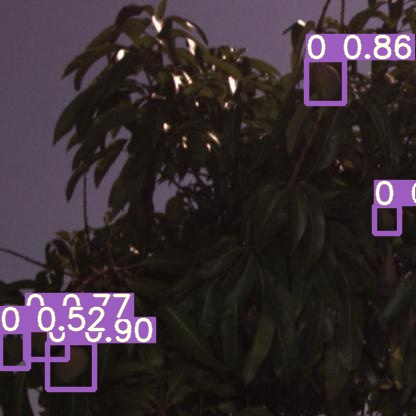

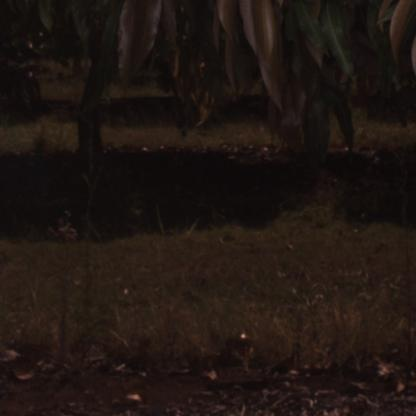

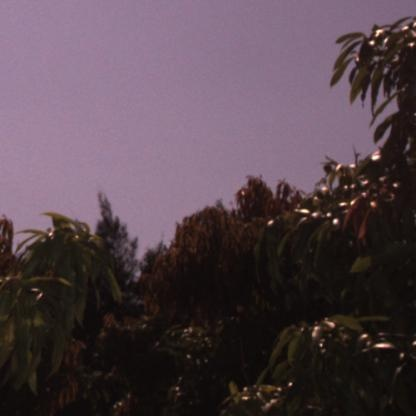

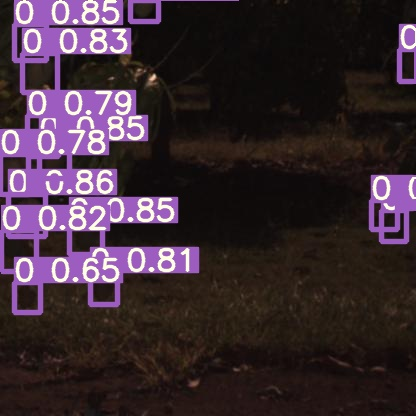

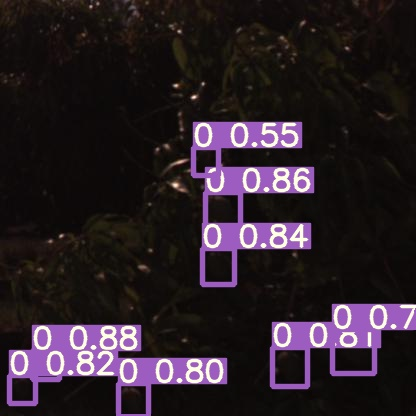

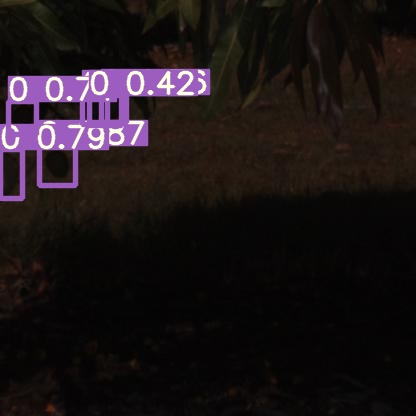

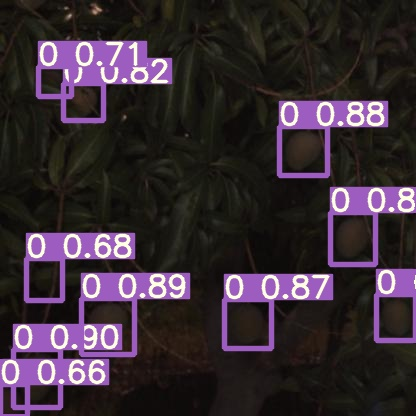

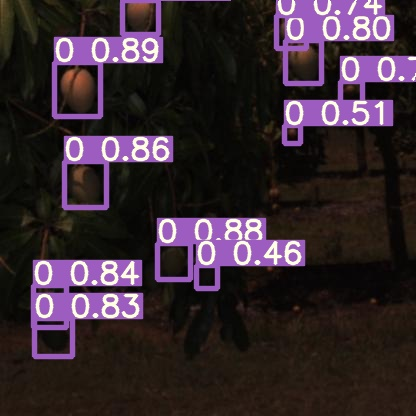

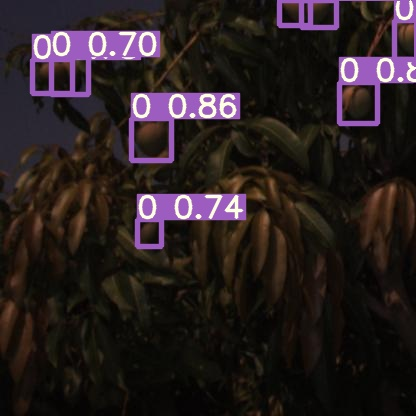

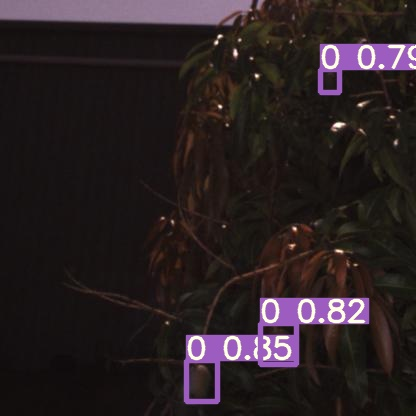

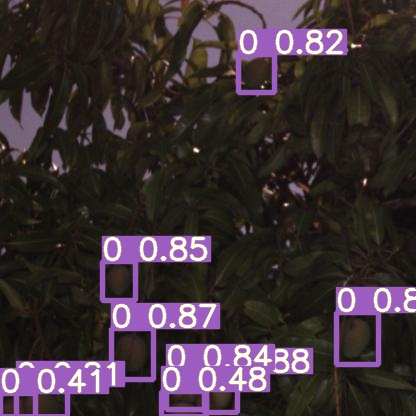

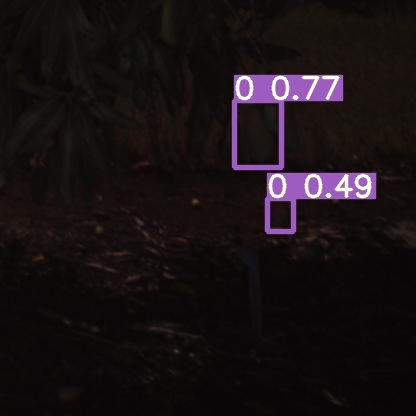

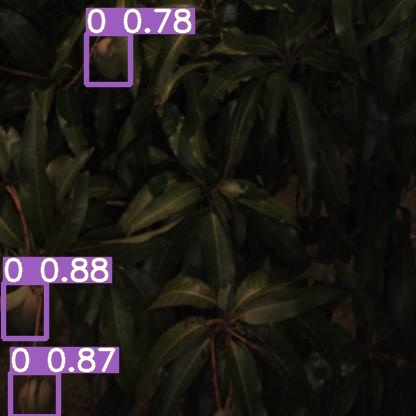

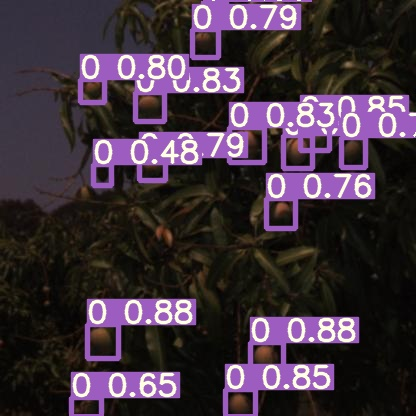

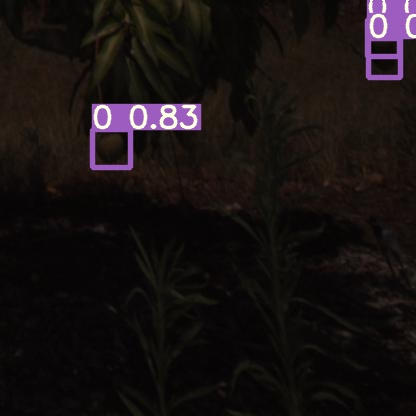

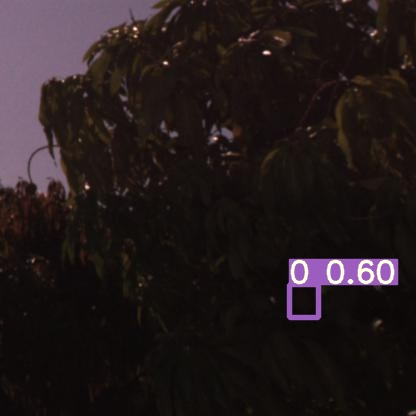

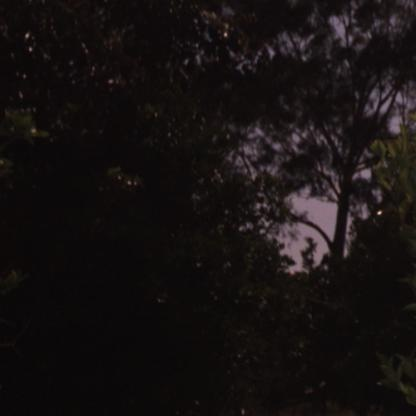

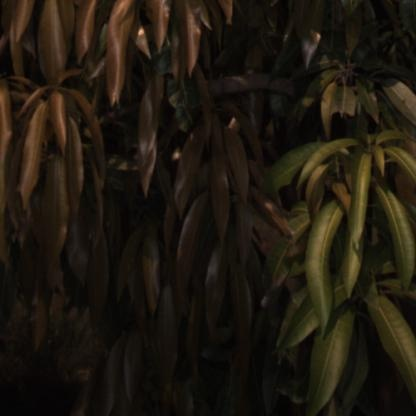

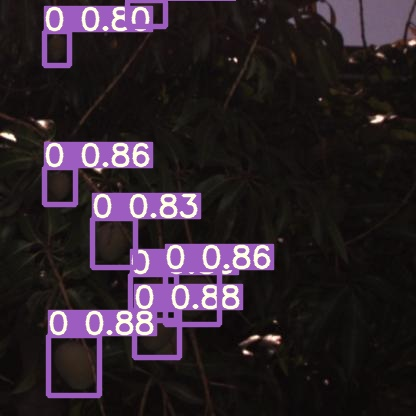

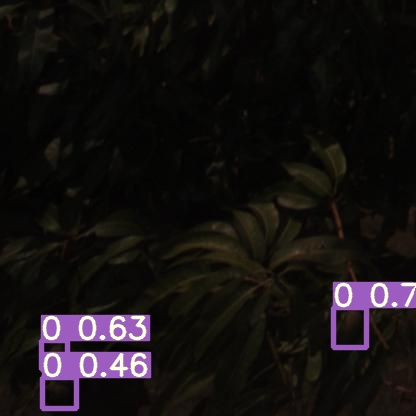

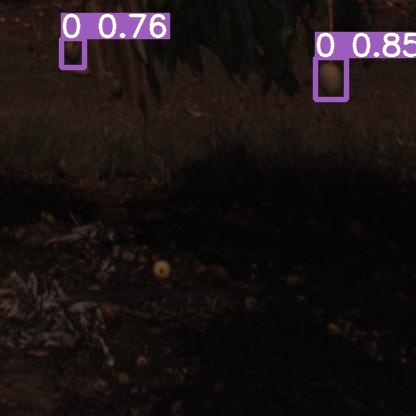

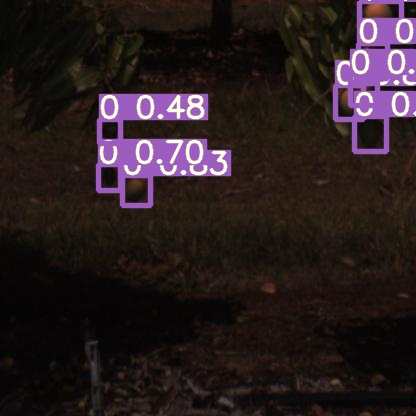

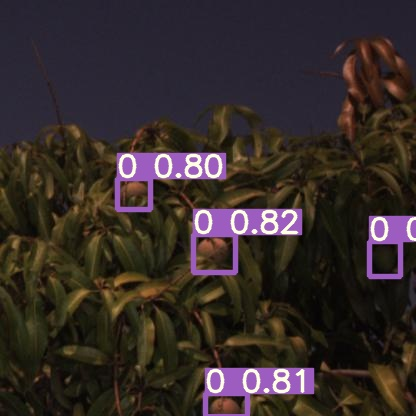

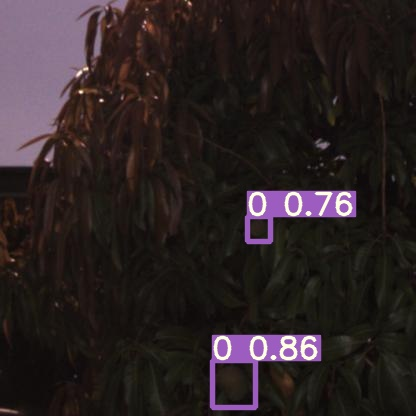

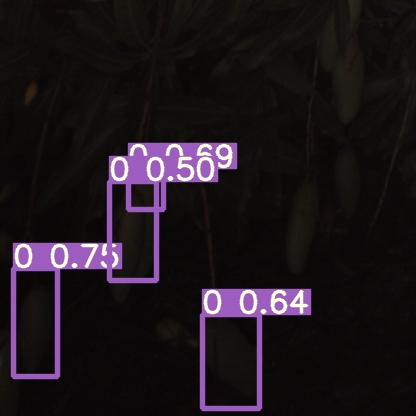

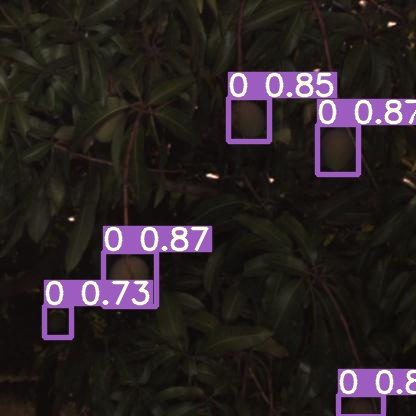

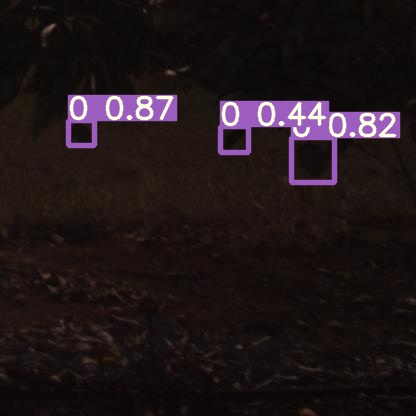

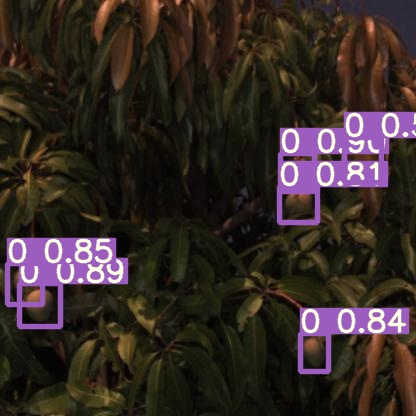

In [14]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/inference/output/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


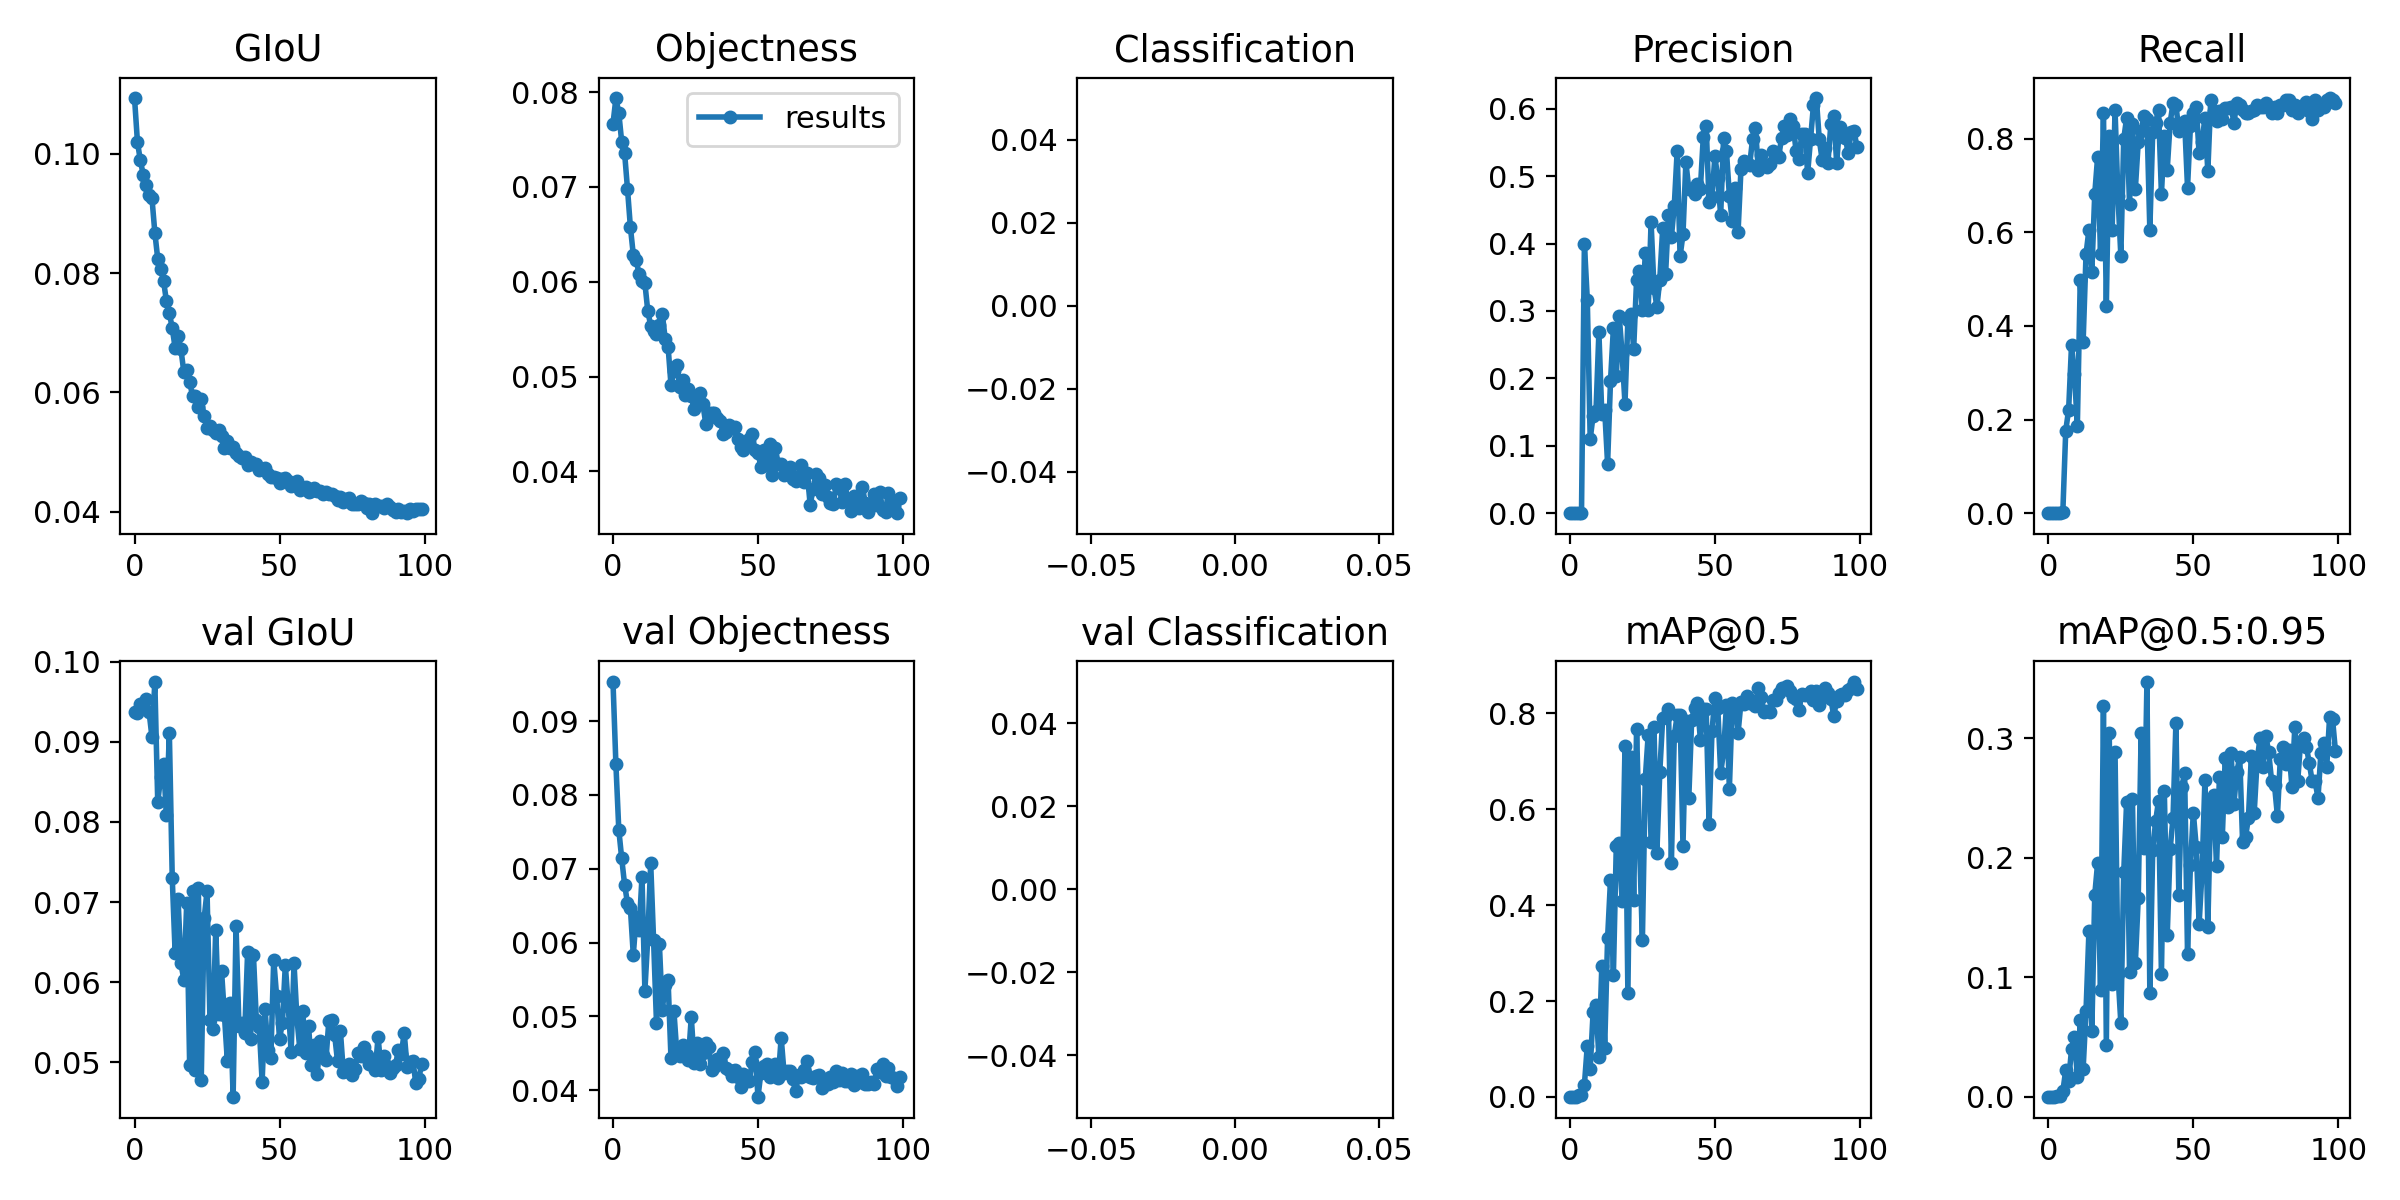

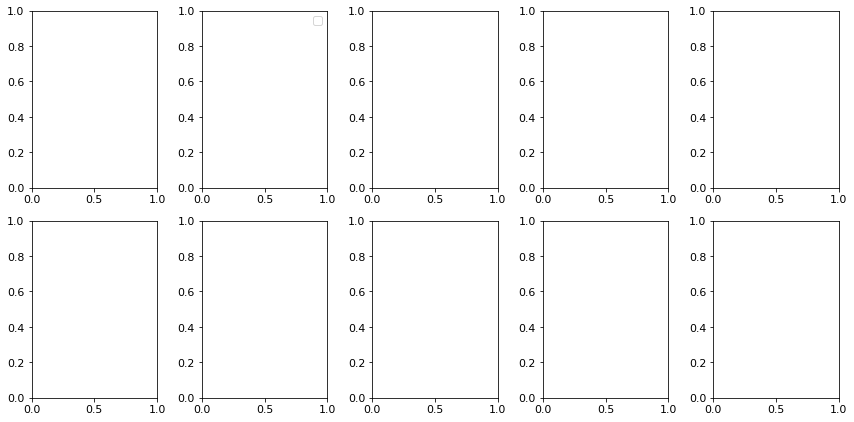

In [ ]:
from utils.utils import plot_results; plot_results() 
Image(filename='/content/yolov5/runs/exp3_yolov5s_results/results.png', width=1000) 

In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=416, iou_thres=0.5, output='inference/output', save_txt=False, source='/mydrive/Yolov5_attempts/mango_img_2.png', update=False, view_img=False, weights=['/mydrive/Yolov5_attempts/last_yolov5s_results.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Fusing layers... Model Summary: 120 layers, 6.85311e+06 parameters, 6.31725e+06 gradients
image 1/1 /mydrive/Yolov5_attempts/mango_img_2.png: 416x416 6 0s, Done. (0.009s)
Results saved to /content/yolov5/inference/output
Done. (0.054s)


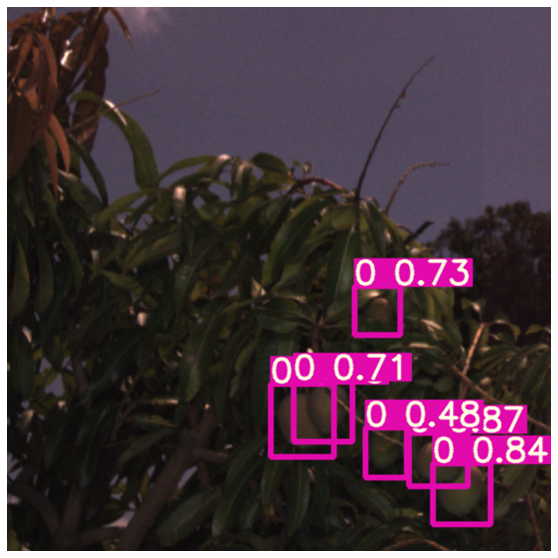

In [ ]:
!python detect.py --weights /mydrive/Yolov5_attempts/last_yolov5s_results.pt --img 416 --conf 0.4 --source /mydrive/Yolov5_attempts/mango_img_2.png
imShow('/content/yolov5/inference/output/mango_img_2.png')

In [ ]:
!python detect.py --weights /mydrive/Yolov5_attempts/last_yolov5s_results.pt --img 416 --conf 0.4 --source /mydrive/Yolov4_tiny_attempts/images/mng_img.png
imShow('/content/yolov5/inference/output/mango_img_2.png')

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=416, iou_thres=0.5, output='inference/output', save_txt=False, source='/mydrive/Yolov4_tiny_attempts/images/mng_img.png', update=False, view_img=False, weights=['/mydrive/Yolov5_attempts/last_yolov5s_results.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Fusing layers... Model Summary: 120 layers, 6.85311e+06 parameters, 6.31725e+06 gradients
image 1/1 /mydrive/Yolov4_tiny_attempts/images/mng_img.png: 416x416 12 0s, Done. (0.010s)
Results saved to /content/yolov5/inference/output
Done. (0.482s)


AttributeError: ignored